# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [1]:
# Import your libraries:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

# Challenge 1 - Import and Describe the Dataset

In this lab, we will use a dataset containing information about customer preferences. We will look at how much each customer spends in a year on each subcategory in the grocery store and try to find similarities using clustering.

The origin of the dataset is [here](https://archive.ics.uci.edu/ml/datasets/wholesale+customers).

In [3]:
# loading the data:

whole_cust = pd.read_csv('../data/Wholesale customers data.csv')
whole_cust.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


#### Explore the dataset with mathematical and visualization techniques. What do you find?

Checklist:

* What does each column mean?
* Any categorical data to convert?
* Any missing data to remove?
* Column collinearity - any high correlations?
* Descriptive statistics - any outliers to remove?
* Column-wise data distribution - is the distribution skewed?
* Etc.

Additional info: Over a century ago, an Italian economist named Vilfredo Pareto discovered that roughly 20% of the customers account for 80% of the typical retail sales. This is called the [Pareto principle](https://en.wikipedia.org/wiki/Pareto_principle). Check if this dataset displays this characteristic.

In [3]:
# check columns info
# All columns are numeric
# There are no missing values to remove
whole_cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [4]:
# Channel and Region columns are Nominal - Categorical avriables already converted to numerical

C:\Users\carlo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Channel', ylabel='count'>

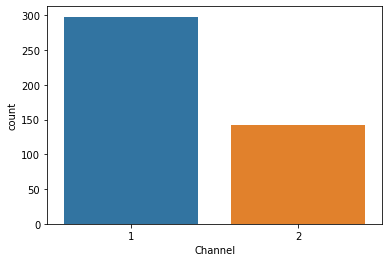

In [5]:
# For Channel, there are two different labels
# 1 = Horeca - 298 observations
# 2 = Retail - 142 observations
sns.countplot(whole_cust['Channel'])

C:\Users\carlo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Region', ylabel='count'>

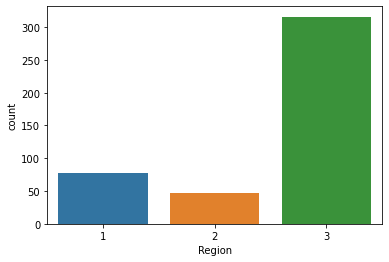

In [6]:
# For Region, there are 3 different labels
# 1 = Lisbon - 77 obersvations
# 2 = Porto - 47 observation
# 3 = Other - 316 observation
sns.countplot(whole_cust['Region'])

In [7]:
# The rest of the variables are continuous and indicate the annual spending quanity per product
continuous = whole_cust.iloc[:,2:8]

<AxesSubplot:>

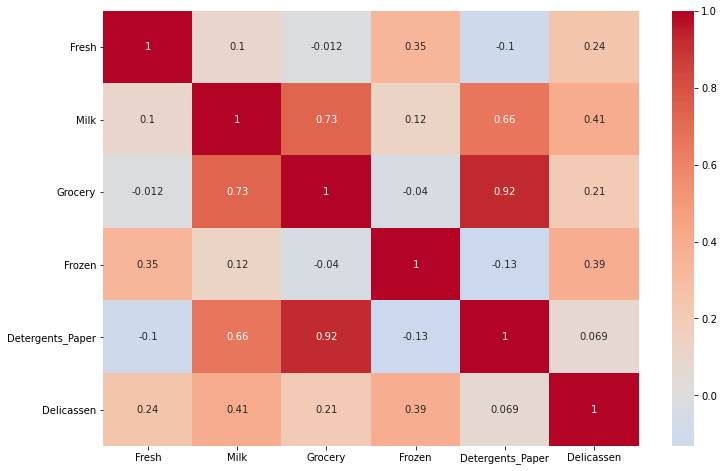

In [9]:
# Check how correlated are these continuous variables
# There are only 2 variables that have a correlation higher than 0.9: Grocery and Detergents Paper
# I will not delete them as they have affect slightly different to other variables
plt.subplots(1,1,figsize=(12,8))
sns.heatmap(continuous.corr(), cmap='coolwarm', annot=True, center=0)

<AxesSubplot:>

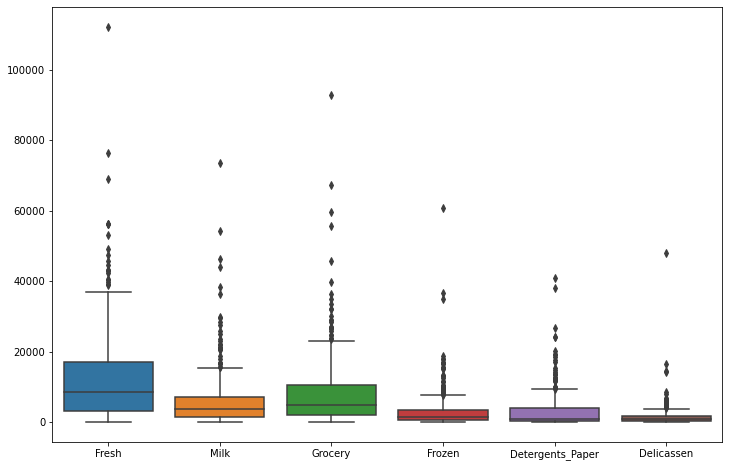

In [10]:
# To make a small general overview and comparision, I will create a boxplot with all the continuous variables
# We can easily see that the values differ between subcategories and we will probably need to scale them
# All subcategories have outliers - we reforce the fact of scaling
plt.subplots(1,1,figsize=(12,8))
sns.boxplot(data = continuous)

C:\Users\carlo\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


NormaltestResult(statistic=274.341626620409, pvalue=2.675917385588268e-60)

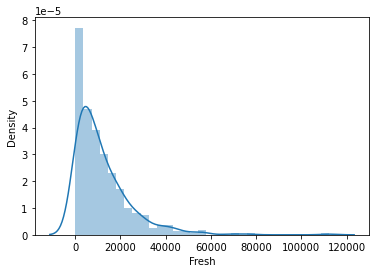

In [12]:
# Distribution of column Fresh
# By looking into the graph we can see that the distribution does not seem normal
# Normaltest to confirm
sns.distplot(continuous['Fresh'])
stats.normaltest(continuous['Fresh'])

C:\Users\carlo\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


NormaltestResult(statistic=410.6536426021092, pvalue=6.725034586236849e-90)

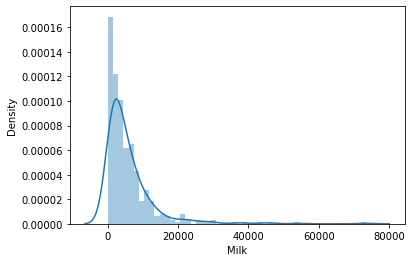

In [18]:
# Distribution of Column Milk
# By looking into the graph we can see that the distribution does not seem normal
# Normaltest to confirm
sns.distplot(continuous['Milk'])
stats.normaltest(continuous['Milk'])

C:\Users\carlo\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


NormaltestResult(statistic=374.02330569249045, pvalue=6.051612583576802e-82)

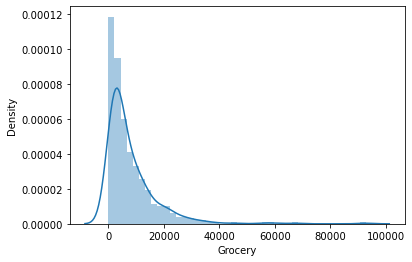

In [17]:
# Distribution of column Grocery
# By looking into the graph we can see that the distribution does not seem normal
# Normaltest to confirm
sns.distplot(continuous['Grocery'])
stats.normaltest(continuous['Grocery'])

C:\Users\carlo\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


NormaltestResult(statistic=546.9039964068573, pvalue=1.7430350282461951e-119)

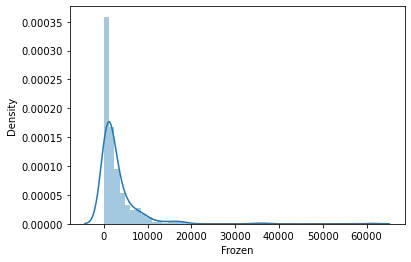

In [16]:
# Distribution of column Frozen
# By looking into the graph we can see that the distribution does not seem normal
# Normaltest to confirm
sns.distplot(continuous['Frozen'])
stats.normaltest(continuous['Frozen'])

C:\Users\carlo\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


NormaltestResult(statistic=371.81993263618244, pvalue=1.8210735948002004e-81)

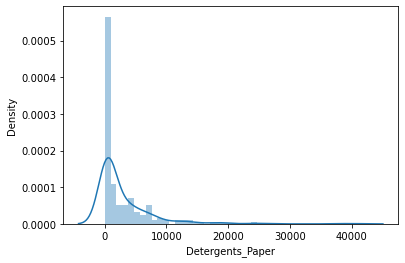

In [15]:
# Distribution of column Detergents_Paper
# By looking into the graph we can see that the distribution does not seem normal
# Normaltest to confirm
sns.distplot(continuous['Detergents_Paper'])
stats.normaltest(continuous['Detergents_Paper'])

C:\Users\carlo\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


NormaltestResult(statistic=793.2983304166767, pvalue=5.4633157170835384e-173)

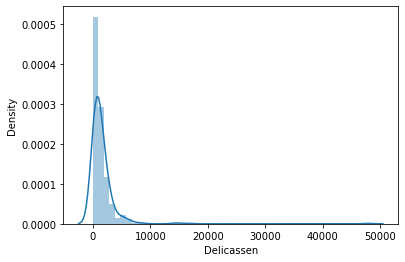

In [14]:
# Distribution of column Delicassen
# By looking into the graph we can see that the distribution does not seem normal
# Normaltest to confirm
sns.distplot(continuous['Delicassen'])
stats.normaltest(continuous['Delicassen'])

In [22]:
# In conclusion, none of the continuous variables have a normal distribution

In [19]:
# Create a new variable with the total annual spending of all products
whole_cust['Total'] = whole_cust['Fresh'] + whole_cust['Milk'] + whole_cust['Grocery'] + whole_cust['Frozen'] + whole_cust['Detergents_Paper'] + whole_cust['Delicassen']

In [20]:
# Create a variable of the weight of the annual spending of all products that each row has
# Check that the sum is equal to one
whole_cust['Total_weight'] = whole_cust['Total'].apply(lambda x: x / whole_cust['Total'].sum())
whole_cust['Total_weight'].sum()

1.0

In [21]:
# I will check if the 20% of the customers with biggest height produce more than the 80% of the total annual spending
# Sort values of Total_weight in descending format
# Calculate which would be the 20% of customers
# Sum the weight of 20% of top customers for annual spending
# Pareto principle does not apply
round(whole_cust.sort_values('Total_weight', ascending=False)['Total_weight'][0:int(len(whole_cust)*0.2)].sum(),2)

0.43

In [22]:
# The Pareto principle would not apply even if we look at subcategories
for i in continuous.columns:
    print(f'20% top customers of {i} subcategory account for a {round(whole_cust.sort_values(i, ascending=False)[i][0:int(len(whole_cust)*0.2)].sum()/whole_cust[i].sum(),2)} of the annual spending')

20% top customers of Fresh subcategory account for a 0.53 of the annual spending
20% top customers of Milk subcategory account for a 0.56 of the annual spending
20% top customers of Grocery subcategory account for a 0.56 of the annual spending
20% top customers of Frozen subcategory account for a 0.62 of the annual spending
20% top customers of Detergents_Paper subcategory account for a 0.7 of the annual spending
20% top customers of Delicassen subcategory account for a 0.57 of the annual spending


# Challenge 2 - Data Cleaning and Transformation

If your conclusion from the previous challenge is the data need cleaning/transformation, do it in the cells below. However, if your conclusion is the data need not be cleaned or transformed, feel free to skip this challenge. But if you do choose the latter, please provide rationale.

In [28]:
# I decided not to clean nor transform
# Dataset is already very clean - no missing values and no categorical variables
# Not need to transform - there are many outliers and the distributions are not normal

# It will only be needed to scale data

# Challenge 3 - Data Preprocessing

One problem with the dataset is the value ranges are remarkably different across various categories (e.g. `Fresh` and `Grocery` compared to `Detergents_Paper` and `Delicassen`). If you made this observation in the first challenge, you've done a great job! This means you not only completed the bonus questions in the previous Supervised Learning lab but also researched deep into [*feature scaling*](https://en.wikipedia.org/wiki/Feature_scaling). Keep on the good work!

Diverse value ranges in different features could cause issues in our clustering. The way to reduce the problem is through feature scaling. We'll use this technique again with this dataset.

#### We will use the `StandardScaler` from `sklearn.preprocessing` and scale our data. Read more about `StandardScaler` [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler).

*After scaling your data, assign the transformed data to a new variable `customers_scale`.*

In [41]:
# Your import here:
from sklearn.preprocessing import StandardScaler

# Create the object and scale the dataset
standard = StandardScaler()
customers_scale = standard.fit_transform(whole_cust)

# Challenge 3 - Data Clustering with K-Means

Now let's cluster the data with K-Means first. Initiate the K-Means model, then fit your scaled data. In the data returned from the `.fit` method, there is an attribute called `labels_` which is the cluster number assigned to each data record. What you can do is to assign these labels back to `customers` in a new column called `customers['labels']`. Then you'll see the cluster results of the original data.

In [42]:
# Your import here:
from sklearn.cluster import KMeans

# Create the object and fit it with scalar data
cl = KMeans()
cl.fit(customers_scale)

# Create a new column in the initial DataFrame
whole_cust['labels'] = cl.labels_

Count the values in `labels`.

C:\Users\carlo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='labels', ylabel='count'>

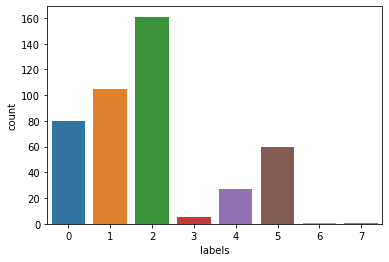

In [43]:
# There are 8 different labels / clusters
sns.countplot(whole_cust['labels'])

# Challenge 4 - Data Clustering with DBSCAN

Now let's cluster the data using DBSCAN. Use `DBSCAN(eps=0.5)` to initiate the model, then fit your scaled data. In the data returned from the `.fit` method, assign the `labels_` back to `customers['labels_DBSCAN']`. Now your original data have two labels, one from K-Means and the other from DBSCAN.

In [44]:
# Your import here:
from sklearn.cluster import DBSCAN

# Create the object and fit it with scalar data
db = DBSCAN()
db.fit(customers_scale)

# Create a new column in the initial DataFrame
whole_cust['labels_DB'] = db.labels_

Count the values in `labels_DBSCAN`.

C:\Users\carlo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='labels_DB', ylabel='count'>

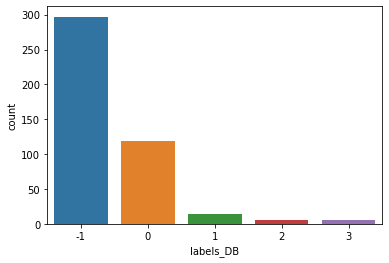

In [45]:
# There are 5 different labels / clusters
# Labels 1, 2 and 3 varely have observations
sns.countplot(whole_cust['labels_DB'])

# Challenge 5 - Compare K-Means with DBSCAN

Now we want to visually compare how K-Means and DBSCAN have clustered our data. We will create scatter plots for several columns. For each of the following column pairs, plot a scatter plot using `labels` and another using `labels_DBSCAN`. Put them side by side to compare. Which clustering algorithm makes better sense?

Columns to visualize:

* `Detergents_Paper` as X and `Milk` as y
* `Grocery` as X and `Fresh` as y
* `Frozen` as X and `Delicassen` as y

In [46]:
# First of all I will switch the type of the labels to string to better visualize the colors
whole_cust['labels'] = whole_cust['labels'].apply(lambda x: str(x))
whole_cust['labels_DB'] = whole_cust['labels_DB'].apply(lambda x: str(x))

Visualize `Detergents_Paper` as X and `Milk` as y by `labels` and `labels_DBSCAN` respectively

<AxesSubplot:xlabel='Detergents_Paper', ylabel='Milk'>

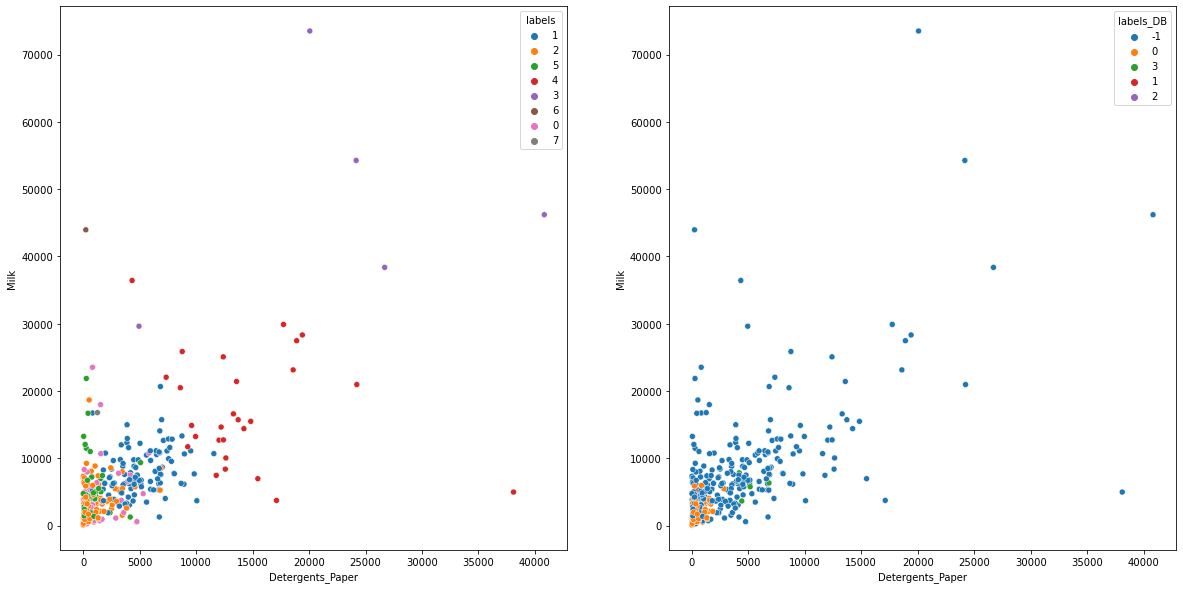

In [47]:
# Conclusions
fig, ax = plt.subplots(1,2, figsize=(20,10))
sns.scatterplot(x = whole_cust['Detergents_Paper'], y=whole_cust['Milk'], hue=whole_cust['labels'], ax=ax[0])
sns.scatterplot(x = whole_cust['Detergents_Paper'], y=whole_cust['Milk'], hue=whole_cust['labels_DB'], ax=ax[1])

Visualize `Grocery` as X and `Fresh` as y by `labels` and `labels_DBSCAN` respectively

<AxesSubplot:xlabel='Grocery', ylabel='Fresh'>

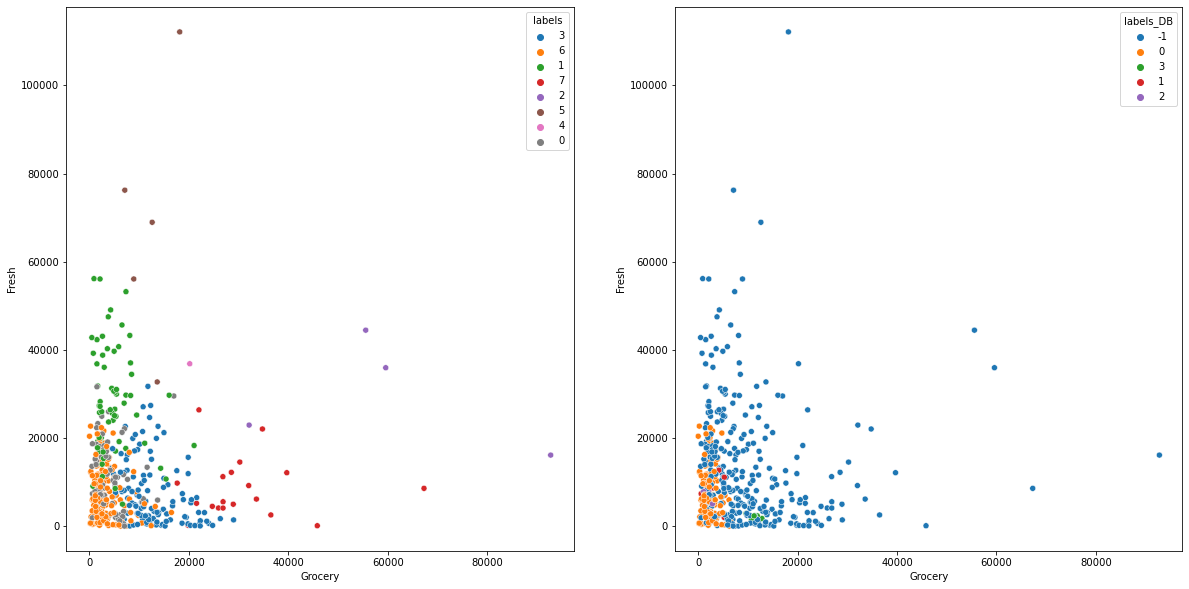

In [39]:
# Conclusions
fig, ax = plt.subplots(1,2, figsize=(20,10))
sns.scatterplot(x = whole_cust['Grocery'], y=whole_cust['Fresh'], hue=whole_cust['labels'], ax=ax[0])
sns.scatterplot(x = whole_cust['Grocery'], y=whole_cust['Fresh'], hue=whole_cust['labels_DB'], ax=ax[1])

Visualize `Frozen` as X and `Delicassen` as y by `labels` and `labels_DBSCAN` respectively

<AxesSubplot:xlabel='Frozen', ylabel='Delicassen'>

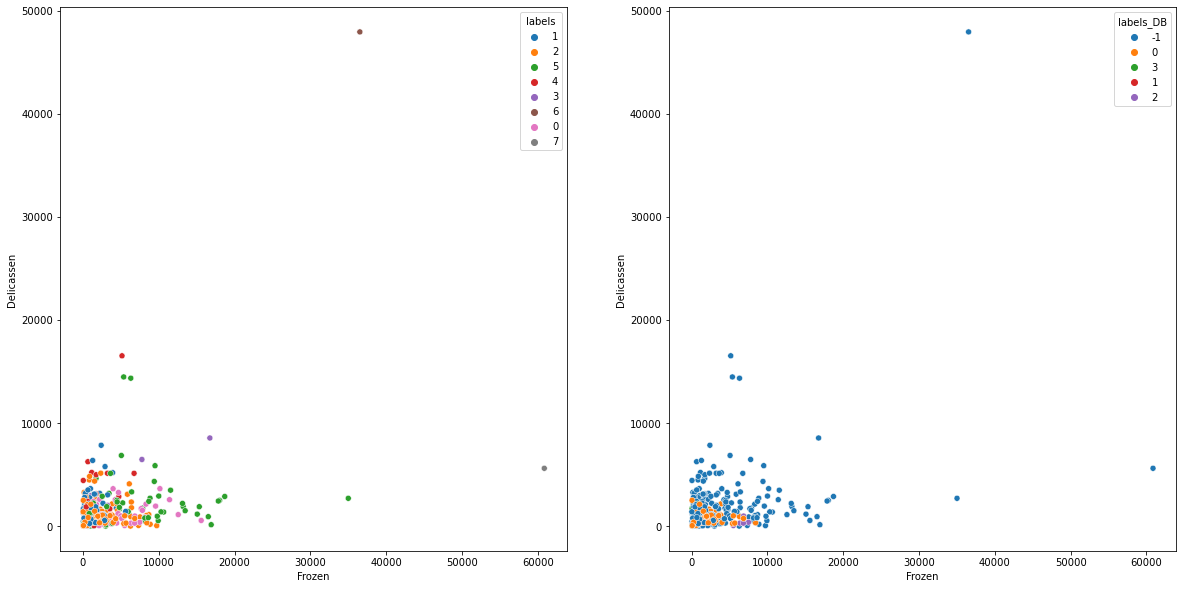

In [48]:
# Conclusions
fig, ax = plt.subplots(1,2, figsize=(20,10))
sns.scatterplot(x = whole_cust['Frozen'], y=whole_cust['Delicassen'], hue=whole_cust['labels'], ax=ax[0])
sns.scatterplot(x = whole_cust['Frozen'], y=whole_cust['Delicassen'], hue=whole_cust['labels_DB'], ax=ax[1])

Let's use a groupby to see how the mean differs between the groups. Group `customers` by `labels` and `labels_DBSCAN` respectively and compute the means for all columns.

In [49]:
whole_cust.groupby('labels').mean()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Total,Total_weight
labels,,,,,,,,,,
0,1.0375,1.287500,10326.637500,3134.200000,4025.612500,3233.650000,884.850000,1021.887500,22626.837500,0.001548
1,2.0000,2.723810,8067.609524,7834.485714,12200.000000,1339.352381,5016.628571,1462.609524,35920.685714,0.002457
2,1.0000,2.981366,7785.291925,2713.186335,3216.987578,2121.211180,755.298137,938.192547,17530.167702,0.001199
3,1.8000,3.000000,46320.200000,48390.000000,51642.200000,5958.800000,23343.400000,4175.800000,179830.400000,0.012301
4,2.0000,2.296296,6823.666667,17213.259259,28379.222222,1876.148148,14194.592593,2684.037037,71170.925926,0.004868
5,1.0500,2.800000,31134.416667,4545.583333,5322.200000,7215.966667,787.300000,2294.483333,51299.950000,0.003509
6,1.0000,3.000000,36847.000000,43950.000000,20170.000000,36534.000000,239.000000,47943.000000,185683.000000,0.012701
7,1.0000,2.000000,32717.000000,16784.000000,13626.000000,60869.000000,1272.000000,5609.000000,130877.000000,0.008952


In [43]:
whole_cust.groupby('labels_DB').mean()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Total,Total_weight
labels_DB,,,,,,,,,,
-1,1.461279,2.451178,14030.013468,7620.636364,10505.649832,3615.494949,3973.117845,1902.279461,41647.191919,0.002849
0,1.000000,3.000000,8121.000000,1848.899160,2345.033613,1885.075630,476.243697,720.764706,15397.016807,0.001053
1,1.000000,1.000000,7271.428571,1931.785714,2398.071429,1272.785714,317.000000,620.071429,13811.142857,0.000945
2,1.000000,1.000000,6863.000000,1959.600000,1899.200000,6599.800000,422.800000,397.800000,18142.200000,0.001241
3,2.000000,3.000000,2140.600000,6033.200000,11251.200000,541.200000,4923.200000,1905.000000,26794.400000,0.001833


Which algorithm appears to perform better?

In [ ]:
# Your observations here

# Bonus Challenge 2 - Changing K-Means Number of Clusters

As we mentioned earlier, we don't need to worry about the number of clusters with DBSCAN because it automatically decides that based on the parameters we send to it. But with K-Means, we have to supply the `n_clusters` param (if you don't supply `n_clusters`, the algorithm will use `8` by default). You need to know that the optimal number of clusters differs case by case based on the dataset. K-Means can perform badly if the wrong number of clusters is used.

In advanced machine learning, data scientists try different numbers of clusters and evaluate the results with statistical measures (read [here](https://en.wikipedia.org/wiki/Cluster_analysis#External_evaluation)). We are not using statistical measures today but we'll use our eyes instead. In the cells below, experiment with different number of clusters and visualize with scatter plots. What number of clusters seems to work best for K-Means?

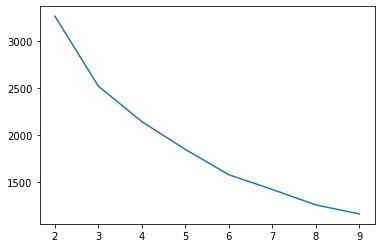

In [56]:
# With .inertia_ we check the global distance from points to its centers, which is useful to know how many classes we need
inertias = [KMeans(k).fit(customers_scale).inertia_ for k in range(2,10)]

# We can graphically check which would be the optimal number
plt.plot(range(2,10), inertias)

# Bonus Challenge 3 - Changing DBSCAN `eps` and `min_samples`

Experiment changing the `eps` and `min_samples` params for DBSCAN. See how the results differ with scatter plot visualization.

In [ ]:
# Your code here

In [ ]:
# Your comment here